<hr style="height:2px;">

# Demo: Denoising of 2D cell images

This notebook demonstrates training a CARE model for a 2D denoising task, assuming that training data was already generated via [1_datagen.ipynb](1_datagen.ipynb) and has been saved to disk to the file ``data/my_training_data.npz``.

Note that training a neural network for actual use should be done on more (representative) data and with more training time.

More Documentation is available at http://csbdeep.bioimagecomputing.com/doc/.

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE

/sw/apps/python3/3.6.5/lib/python3.6/site-packages/tifffile/tifffile.py:7685: UserWarning: No module named 'tifffile._tifffile'
  Functionality might be degraded or be slow.

  warnings.warn('%s%s' % (e, warn))
/sw/apps/python3/3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/sw/apps/python3/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


The TensorFlow backend uses all available GPU memory by default, hence it can be useful to limit it:

In [2]:
# limit_gpu_memory(fraction=1/2)

Remove the models that might already have been trained (if needed)

<hr style="height:2px;">

# Training and validation data

Here we load the data patches generated via [1_datagen.ipynb](1_datagen.ipynb), and split them into 90% actual training data and 10% *validation data*. The latter is used during model training as independent indicator of the restoration accuracy. Model performance on the training data is often better than on the validation data, in which case the model is *overfitting*. Monitoring the validation performance gives us a chance to detect that. 

In [3]:
(X,Y), (X_val,Y_val), axes = load_training_data('data/my_training_data.npz', validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

number of training images:	 1800
number of validation images:	 200
image size (2D):		 (128, 128)
axes:				 SYXC
channels in / out:		 1 / 1


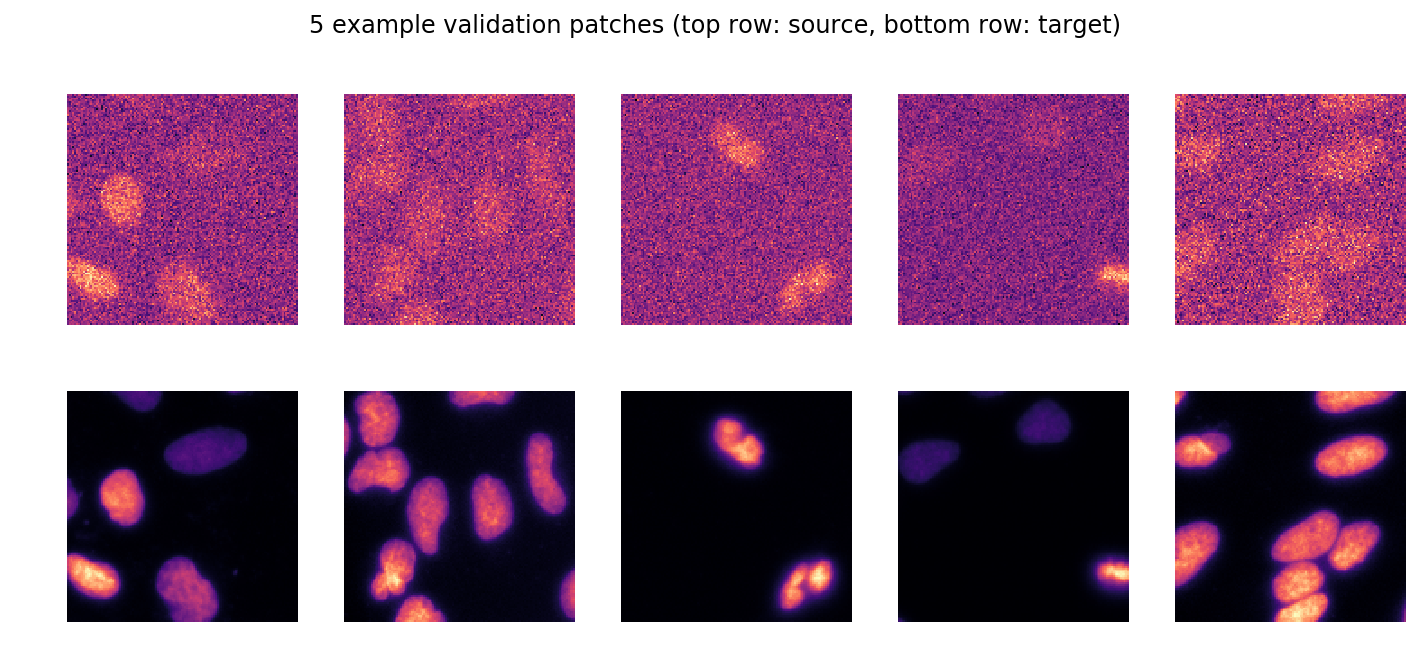

In [4]:
plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

<hr style="height:2px;">

# CARE model


Before we construct the actual CARE model, we have to define its configuration via a `Config` object, which includes 
* parameters of the underlying neural network (a rather small 2D U-Net with 2x max pooling),
* the learning rate,
* the number of parameter updates per epoch,
* the loss function, and
* whether the model is probabilistic or not.

![](imgs/carenet.png)

The defaults should be sensible in many cases, so a change should only be necessary if the training process fails.  

---

<span style="color:red">**Important**</span>: Note that for this notebook we use a very small number of update steps per epoch for immediate feedback, whereas this number should be increased considerably (e.g. `train_steps_per_epoch=400`) to obtain a well-trained model.

In [5]:
config = Config(axes, n_channel_in, n_channel_out,train_batch_size=8, train_steps_per_epoch=50)
print(config)
vars(config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=False, train_batch_size=8, train_checkpoint='weights_best.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10}, train_steps_per_epoch=50, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=5, unet_last_activation='linear', unet_n_depth=2, unet_n_first=32, unet_residual=True)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 5,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 100,
 'train_steps_per_epoch': 50,
 'train_learning_rate': 0.0004,
 'train_batch_size': 8,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10}}

We now create a CARE model with the chosen configuration:

In [6]:
model = CARE(config, 'my_model', basedir='models')

In [7]:
model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, None, 1 0                                            
__________________________________________________________________________________________________
down_level_0_no_0 (Conv2D)      (None, None, None, 3 832         input[0][0]                      
__________________________________________________________________________________________________
down_level_0_no_1 (Conv2D)      (None, None, None, 3 25632       down_level_0_no_0[0][0]          
__________________________________________________________________________________________________
max_0 (MaxPooling2D)            (None, None, None, 3 0           down_level_0_no_1[0][0]          
__________________________________________________________________________________________________
down_level

<hr style="height:2px;">

# Training

Training the model may take some time.

## You can monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard) by starting it from the current working directory:

    $ tensorboard --logdir=. --reload-interval=2

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.

## Alternatively, you can use the jupyter_tensorboard extension (should be activated).

In [8]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

Epoch 1/100
50/50 [==============================] - 4s 82ms/step - loss: 0.1731 - mse: 0.0514 - mae: 0.1731 - val_loss: 0.1229 - val_mse: 0.0262 - val_mae: 0.1229
Epoch 2/100
50/50 [==============================] - 3s 51ms/step - loss: 0.1091 - mse: 0.0221 - mae: 0.1091 - val_loss: 0.0910 - val_mse: 0.0193 - val_mae: 0.0910
Epoch 3/100
50/50 [==============================] - 3s 51ms/step - loss: 0.0921 - mse: 0.0170 - mae: 0.0921 - val_loss: 0.0977 - val_mse: 0.0208 - val_mae: 0.0977
Epoch 4/100
50/50 [==============================] - 3s 51ms/step - loss: 0.0771 - mse: 0.0135 - mae: 0.0771 - val_loss: 0.0727 - val_mse: 0.0111 - val_mae: 0.0727
Epoch 5/100
50/50 [==============================] - 3s 51ms/step - loss: 0.0647 - mse: 0.0094 - mae: 0.0647 - val_loss: 0.0606 - val_mse: 0.0089 - val_mae: 0.0606
Epoch 6/100
50/50 [==============================] - 3s 51ms/step - loss: 0.0598 - mse: 0.0104 - mae: 0.0598 - val_loss: 0.0541 - val_mse: 0.0085 - val_mae: 0.0541
Epoch 7/100
50/5


Epoch 00050: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.
Epoch 51/100
50/50 [==============================] - 3s 52ms/step - loss: 0.0357 - mse: 0.0065 - mae: 0.0357 - val_loss: 0.0329 - val_mse: 0.0056 - val_mae: 0.0329
Epoch 52/100
50/50 [==============================] - 3s 52ms/step - loss: 0.0333 - mse: 0.0050 - mae: 0.0333 - val_loss: 0.0334 - val_mse: 0.0059 - val_mae: 0.0334
Epoch 53/100
50/50 [==============================] - 3s 52ms/step - loss: 0.0330 - mse: 0.0050 - mae: 0.0330 - val_loss: 0.0367 - val_mse: 0.0069 - val_mae: 0.0367
Epoch 54/100
50/50 [==============================] - 3s 52ms/step - loss: 0.0351 - mse: 0.0055 - mae: 0.0351 - val_loss: 0.0327 - val_mse: 0.0057 - val_mae: 0.0327
Epoch 55/100
50/50 [==============================] - 3s 52ms/step - loss: 0.0357 - mse: 0.0056 - mae: 0.0357 - val_loss: 0.0348 - val_mse: 0.0057 - val_mae: 0.0348
Epoch 56/100
50/50 [==============================] - 3s 52ms/step - loss: 0.0327 - mse: 0.00

Epoch 100/100
50/50 [==============================] - 3s 53ms/step - loss: 0.0300 - mse: 0.0045 - mae: 0.0300 - val_loss: 0.0313 - val_mse: 0.0052 - val_mae: 0.0313


Plot final training history (available in TensorBoard during training):

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


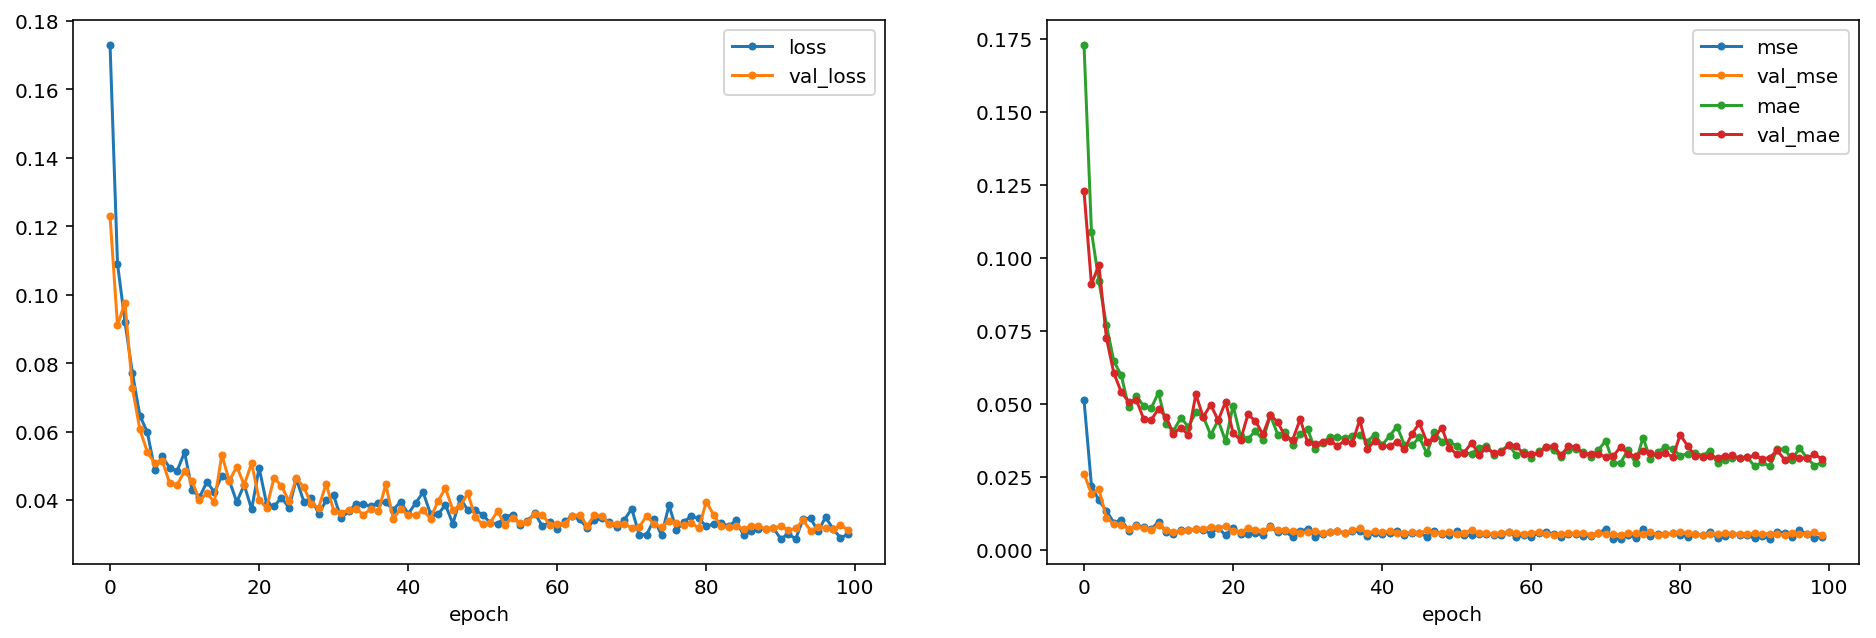

In [9]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

<hr style="height:2px;">

# Evaluation

Example results for validation images.

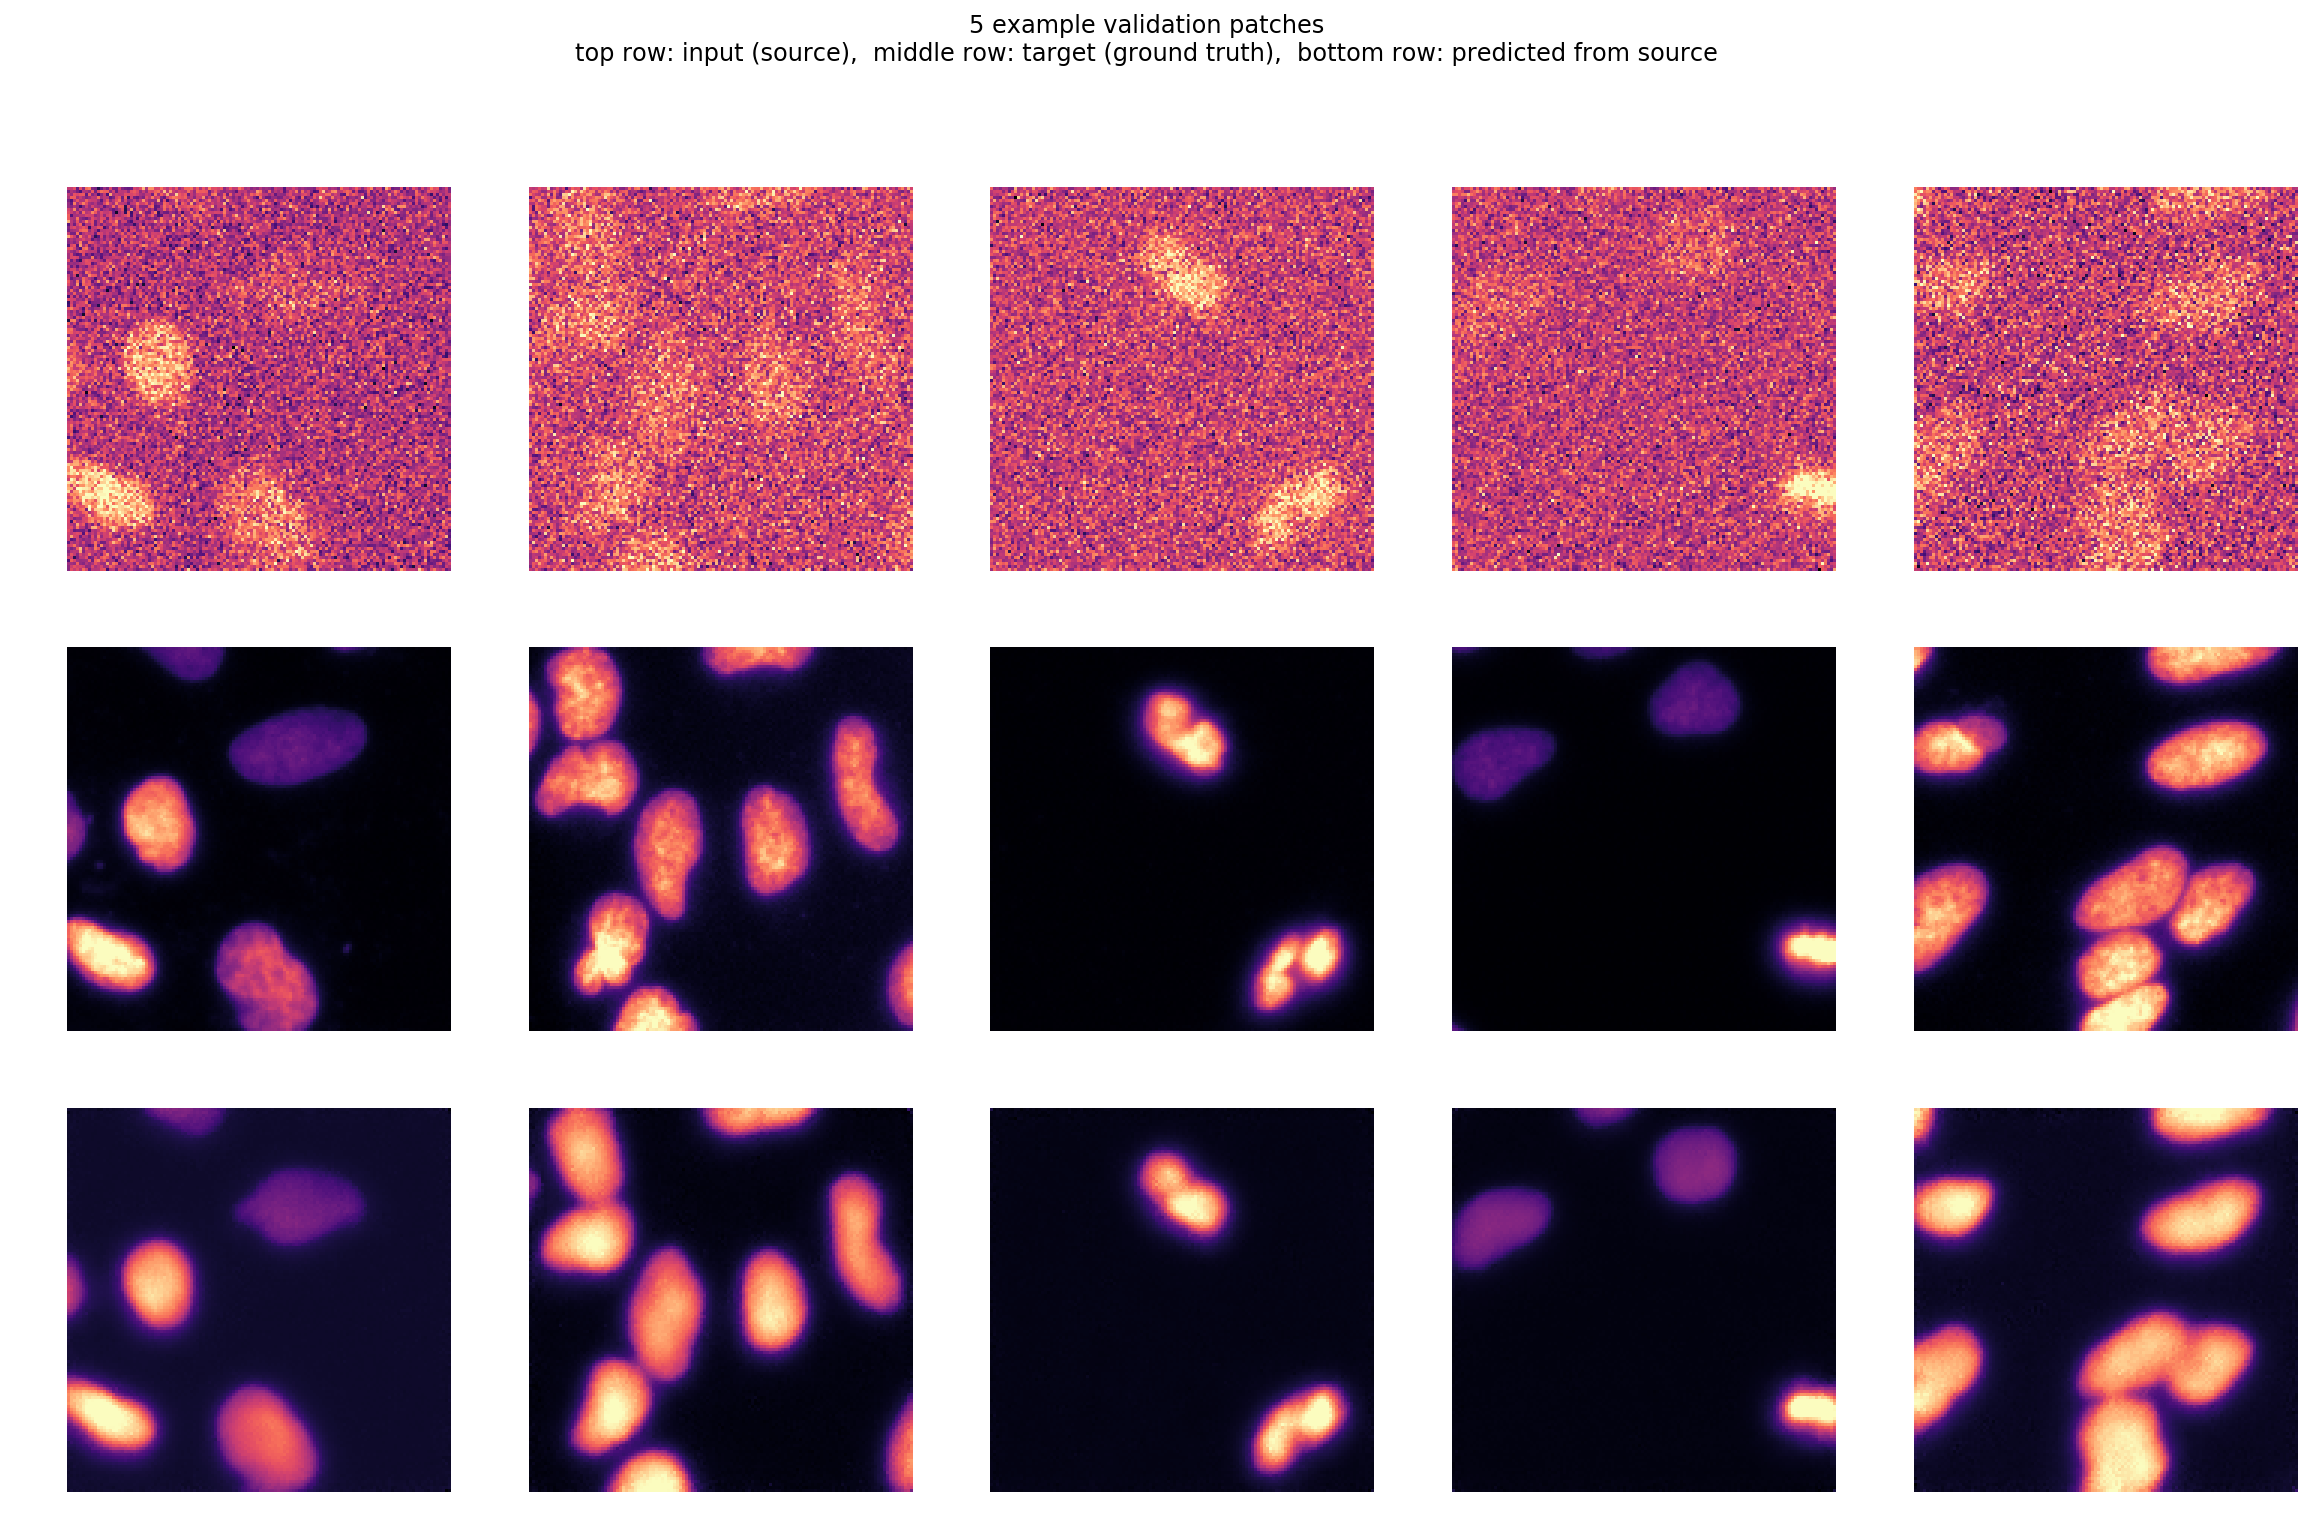

In [10]:
plt.figure(figsize=(20,12))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:5],Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source');

<hr style="height:2px;">

# Export model to be used with CSBDeep **Fiji** plugins and **KNIME** workflows

See https://github.com/CSBDeep/CSBDeep_website/wiki/Your-Model-in-Fiji for details.

In [11]:
model.export_TF()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tmpxato7hmr/model/saved_model.pb

Model exported in TensorFlow's SavedModel format:
/lustre/projects/icarus/16/dlbc18/day4/care/denoising2D/models/my_model/TF_SavedModel.zip


# Shutting down this notebook will relase GPU memory again...